# Analyse Exploratoire des données du Titanic 

In [2]:
import pandas as pd, numpy as np, seaborn as sns, warnings, os, sys, time, copy as cp
from datetime import datetime as dt
from matplotlib import pyplot as plt

import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects


import plotly.express as px
import plotly.graph_objs as go

font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
sns.set(font_scale=2)

os.chdir("C:/Users/etien/Documents/CCI/_HUB/cours/2024-2025/big_data/_git/MachineLearning/donnees/Titanic")


In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans

# Lecture des données 

In [4]:
train = pd.read_csv('train.csv',
                           sep=',',
                           na_values='mq',
                           dtype={'numer_sta':str,'date':str},
                          )

test = pd.read_csv('test.csv',
                           sep=',',
                           na_values='mq',
                           dtype={'numer_sta':str,'date':str},
                          )

donnees = pd.concat([train,test],axis=0)
donnees.sample(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
364,1256,NaN,1,"Harder, Mrs. George Achilles (Dorothy Annan)",female,25.0,1,0,11765,55.4417,E50,C
120,1012,NaN,2,"Watt, Miss. Bertha J",female,12.0,0,0,C.A. 33595,15.7500,NaN,S
164,1056,NaN,2,"Peruschitz, Rev. Joseph Maria",male,41.0,0,0,237393,13.0000,NaN,S
359,360,1.0,3,"Mockler, Miss. Helen Mary ""Ellie""",female,NaN,0,0,330980,7.8792,NaN,Q
316,317,1.0,2,"Kantor, Mrs. Sinai (Miriam Sternin)",female,24.0,1,0,244367,26.0000,NaN,S


In [5]:
donnees.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [6]:
donnees.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
print("### Basic Statistics ###")
print("\nMissing Values:")
print(donnees.isnull().sum())
print("\nBasic Statistics:")
print(donnees.describe())


### Basic Statistics ###

Missing Values:
PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Basic Statistics:
       PassengerId    Survived       Pclass          Age        SibSp  \
count  1309.000000  891.000000  1309.000000  1046.000000  1309.000000   
mean    655.000000    0.383838     2.294882    29.881138     0.498854   
std     378.020061    0.486592     0.837836    14.413493     1.041658   
min       1.000000    0.000000     1.000000     0.170000     0.000000   
25%     328.000000    0.000000     2.000000    21.000000     0.000000   
50%     655.000000    0.000000     3.000000    28.000000     0.000000   
75%     982.000000    1.000000     3.000000    39.000000     1.000000   
max    1309.000000    1.000000     3.000000    80.000000     8.000000   

             Parch         F

In [22]:
for col in donnees.columns:
    print(f"\n{col} : {donnees[col].sort_values().unique()}")


PassengerId : [   1    2    3 ... 1307 1308 1309]

Survived : [ 0.  1. nan]

Pclass : [1 2 3]

Name : ['Abbing, Mr. Anthony' 'Abbott, Master. Eugene Joseph'
 'Abbott, Mr. Rossmore Edward' ... 'van Billiard, Master. Walter John'
 'van Billiard, Mr. Austin Blyler' 'van Melkebeke, Mr. Philemon']

Sex : ['female' 'male']

Age : [ 0.17  0.33  0.42  0.67  0.75  0.83  0.92  1.    2.    3.    4.    5.
  6.    7.    8.    9.   10.   11.   11.5  12.   13.   14.   14.5  15.
 16.   17.   18.   18.5  19.   20.   20.5  21.   22.   22.5  23.   23.5
 24.   24.5  25.   26.   26.5  27.   28.   28.5  29.   29.5  30.   30.5
 31.   32.   32.5  33.   34.   34.5  35.   36.   36.5  37.   38.   38.5
 39.   40.   40.5  41.   42.   43.   44.   45.   45.5  46.   47.   48.
 49.   50.   51.   52.   53.   54.   55.   55.5  56.   57.   58.   59.
 60.   60.5  61.   62.   63.   64.   65.   66.   67.   70.   70.5  71.
 74.   76.   80.  ]

SibSp : [0 1 2 3 4 5 8]

Parch : [0 1 2 3 4 5 6 9]

Ticket : ['110152' '110413' '

In [23]:
donnees[donnees['Cabin'].isna()][donnees['Embarked'].isna()]

KeyError: 'Cabin'

# Gestion des valeurs manquantes

## version automatique

In [9]:
auto_clean_donnees = cp.deepcopy(donnees)

# 1. Handle Age missing values
age_median = donnees.groupby(['Pclass', 'Sex'])['Age'].transform('median')
auto_clean_donnees['Age'] = donnees['Age'].fillna(age_median)

# 2. Handle Fare missing value
fare_median = donnees.groupby('Pclass')['Fare'].transform('median')
auto_clean_donnees['Fare'] = donnees['Fare'].fillna(fare_median)

# 3. Delete missing values for Embarked
donnees = donnees.dropna(subset=['Embarked'])

# 4. Too many missing value for Cabin, so drop it
auto_clean_donnees = auto_clean_donnees.drop('Cabin', axis=1)

# 5. Verify results
print("Missing values after handling :")
print(auto_clean_donnees.isnull().sum())

Missing values after handling :
PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64


## Version réfléchit

## Les 3 moyen de netoyer les données

- d'Emputer la valeur 
- prendre la valeur médianne 
- transormer ma variable en qualitative 

### remplacement des données

In [10]:
donnees = auto_clean_donnees
donnees.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
410,1302,NaN,3,"Naughton, Miss. Hannah",female,22.0,0,0,365237,7.7500,Q
335,336,0.0,3,"Denkoff, Mr. Mitto",male,25.0,0,0,349225,7.8958,S
210,211,0.0,3,"Ali, Mr. Ahmed",male,24.0,0,0,SOTON/O.Q. 3101311,7.0500,S
837,838,0.0,3,"Sirota, Mr. Maurice",male,25.0,0,0,392092,8.0500,S
477,478,0.0,3,"Braund, Mr. Lewis Richard",male,29.0,1,0,3460,7.0458,S


# Analyse exploratoire

Text(0.5, 1.0, 'Overall Survival Rate')

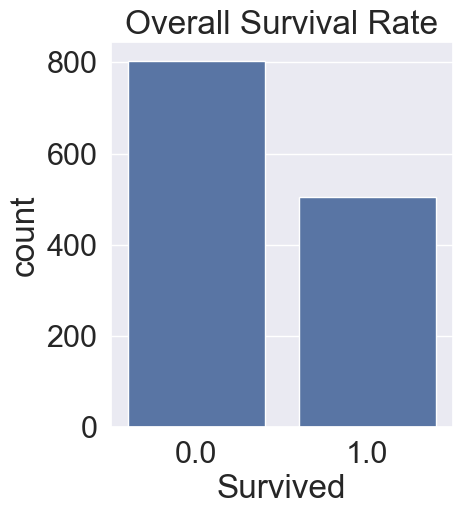

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.countplot(data=donnees, x='Survived')
plt.title('Overall Survival Rate')

Text(0.5, 1.0, 'Survival by Class')

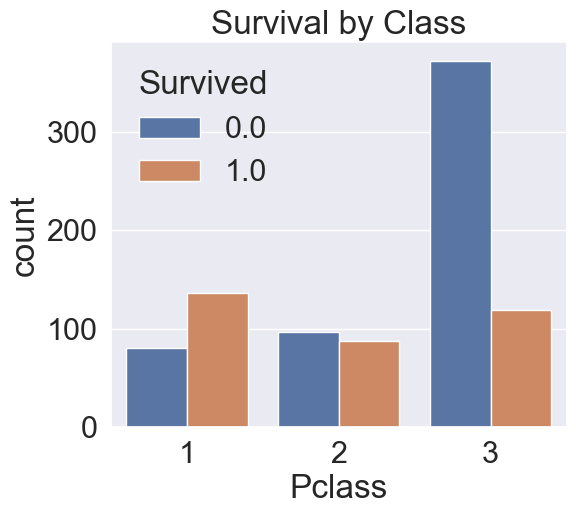

In [12]:
plt.figure(figsize=(20, 5))
plt.subplot(132)
sns.countplot(data=donnees, x='Pclass', hue='Survived')
plt.title('Survival by Class')

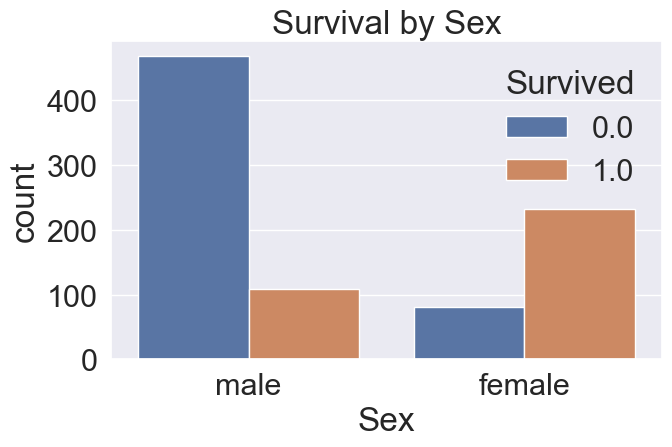

In [13]:
plt.figure(figsize=(20, 5))
plt.subplot(133)
sns.countplot(data=donnees, x='Sex', hue='Survived')
plt.title('Survival by Sex')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Age Distribution')

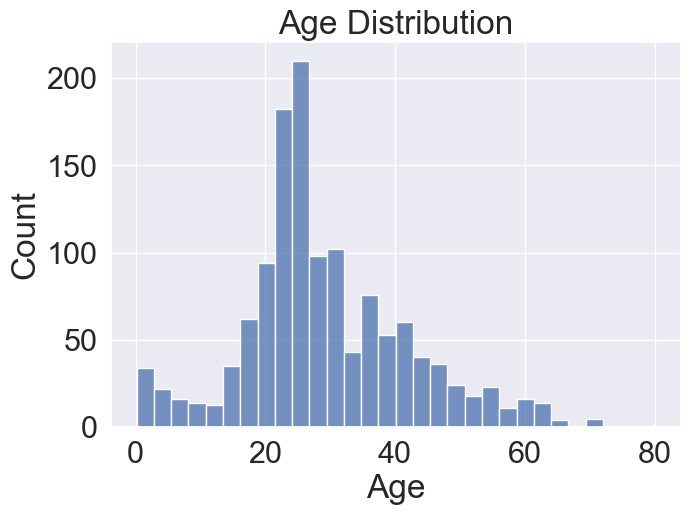

In [14]:
donnees.reset_index(drop=True, inplace=True)
plt.figure(figsize=(25, 5))
plt.subplot(131)
sns.histplot(data=donnees, x='Age', bins=30)
plt.title('Age Distribution')

Text(0.5, 1.0, 'Age vs Survival')

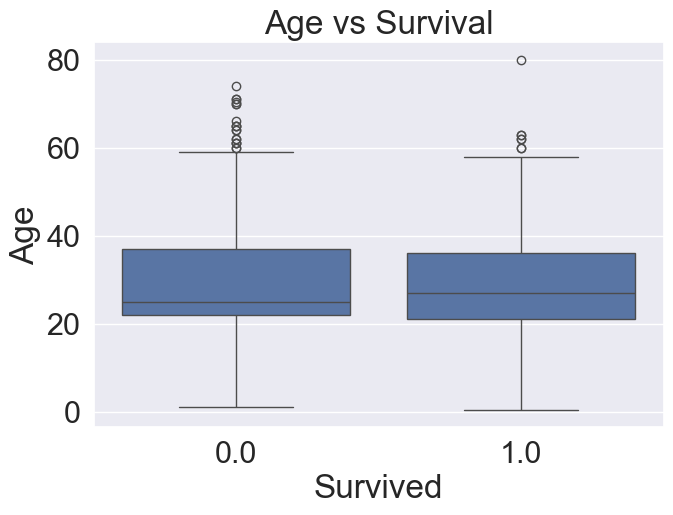

In [15]:
plt.figure(figsize=(25, 5))
plt.subplot(132)
sns.boxplot(data=donnees, x='Survived', y='Age')
plt.title('Age vs Survival')

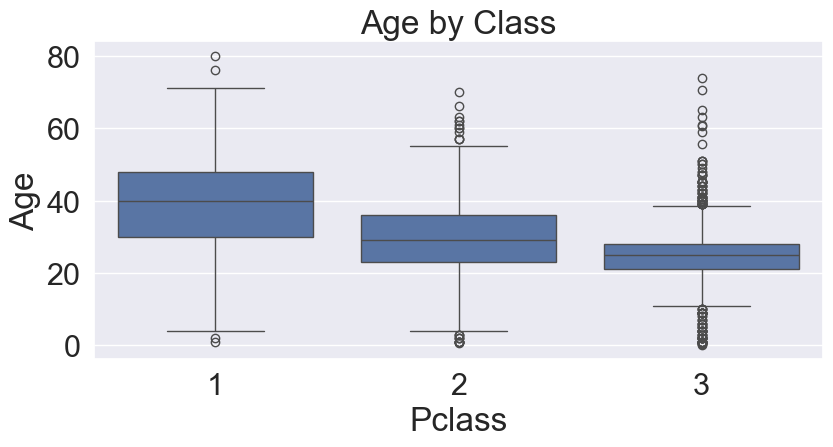

In [16]:
plt.figure(figsize=(25, 5))
plt.subplot(133)
sns.boxplot(data=donnees, x='Pclass', y='Age')
plt.title('Age by Class')
plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'Fare Distribution')

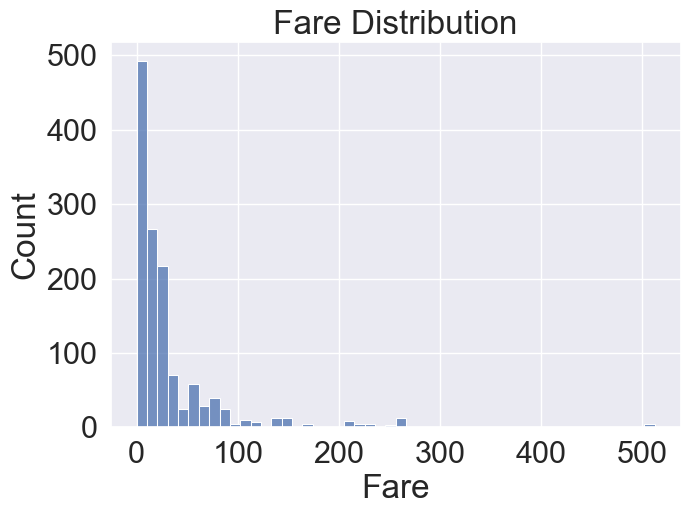

In [17]:
plt.figure(figsize=(25, 5))
plt.subplot(131)
sns.histplot(data=donnees, x='Fare', bins=50)
plt.title('Fare Distribution')

Text(0.5, 1.0, 'Fare by Class')

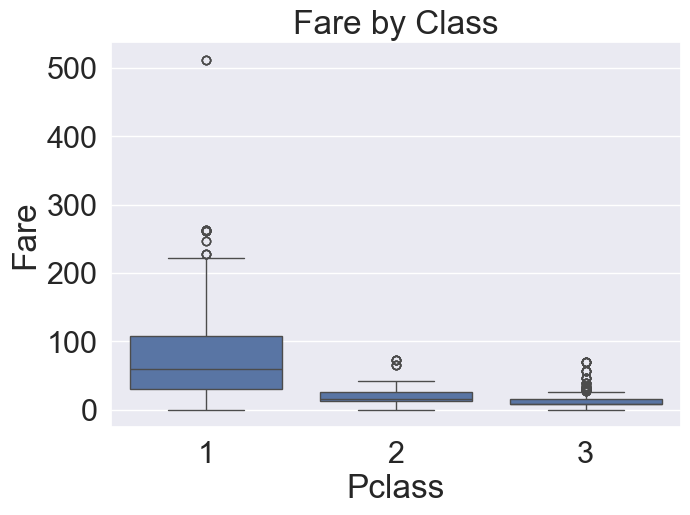

In [18]:
plt.figure(figsize=(25, 5))
plt.subplot(132)
sns.boxplot(data=donnees, x='Pclass', y='Fare')
plt.title('Fare by Class')

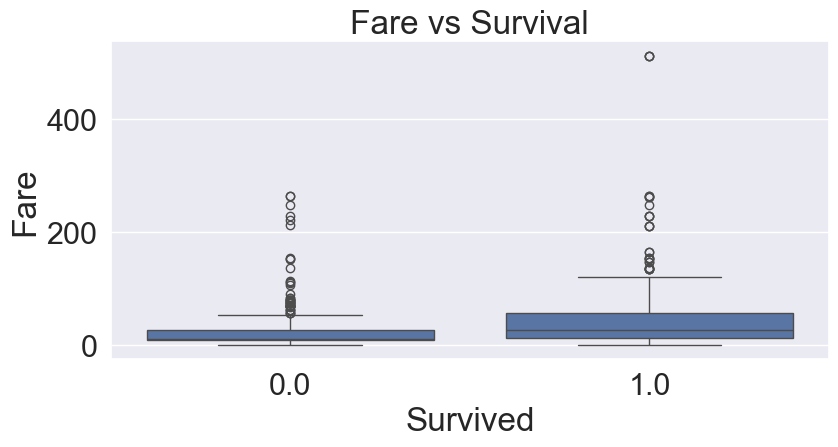

In [19]:
plt.figure(figsize=(25, 5))
plt.subplot(133)
sns.boxplot(data=donnees, x='Survived', y='Fare')
plt.title('Fare vs Survival')
plt.tight_layout()
plt.show()


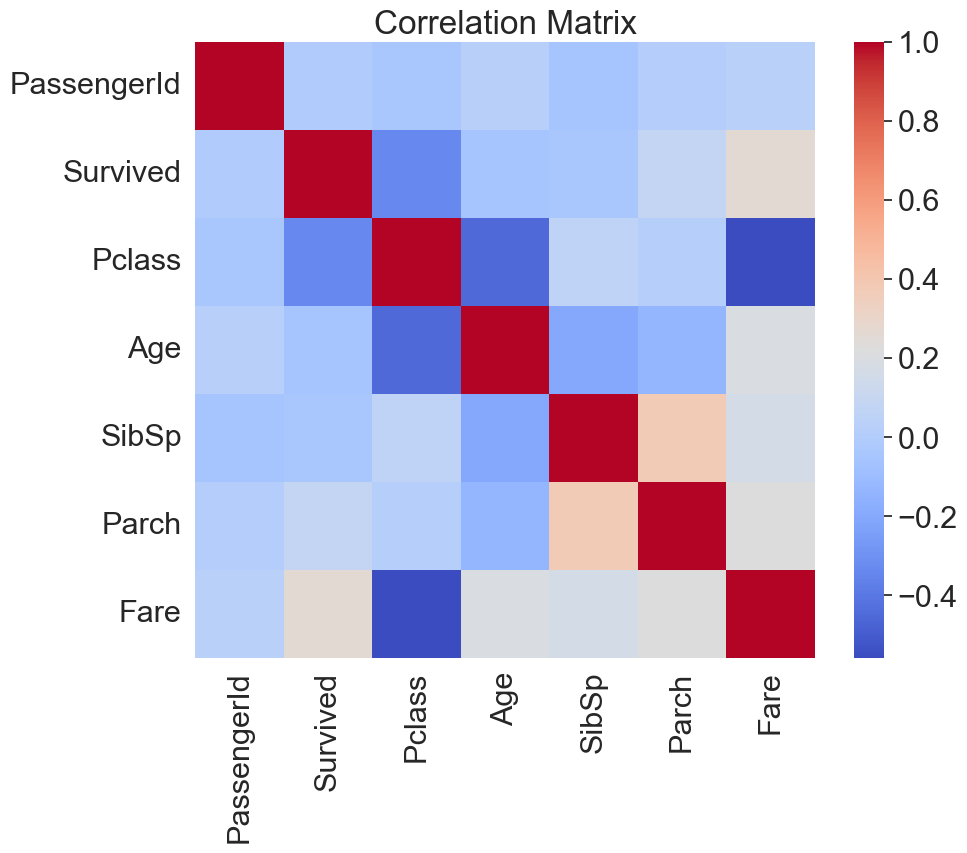

In [20]:
plt.figure(figsize=(10, 8))
numeric_cols = donnees.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(donnees[numeric_cols].corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

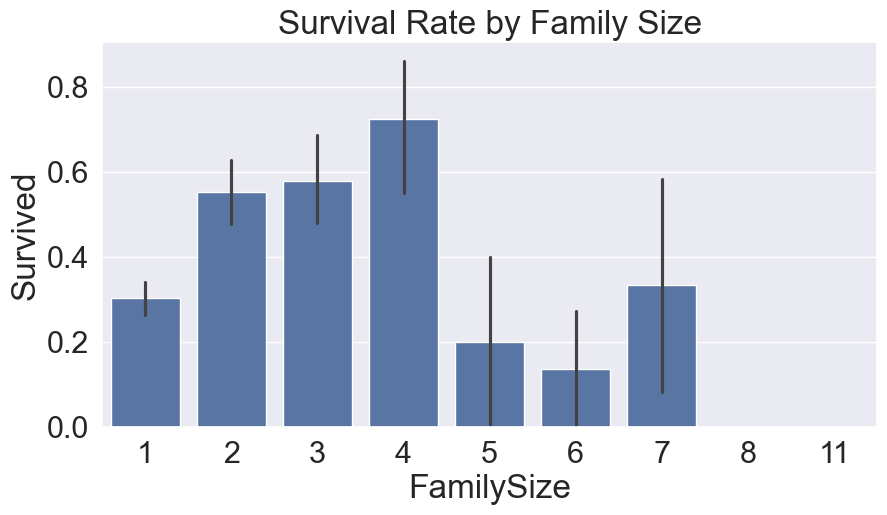

In [21]:
donnees['FamilySize'] = donnees['SibSp'] + donnees['Parch'] + 1
plt.figure(figsize=(10, 5))
sns.barplot(data=donnees, x='FamilySize', y='Survived')
plt.title('Survival Rate by Family Size')
plt.show()